In [0]:
# mount to google drive
from google.colab import drive
drive.mount('/content/gdrive')
#drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# import relevant libraries
import pandas as pd
import numpy as np
import nltk
from nltk import tokenize
import xml.etree.ElementTree as et
import re

## Upload Trec XML to Pandas

In [0]:
with open('./gdrive/My Drive/trec.xml', 'r', encoding ='ISO-8859-1') as f:
  xml = et.parse(f)
root = xml.getroot()
rows = root.findall('DOC')
xml_data = []

for row in rows:
  x = []
  x.append(row.find('DOCNO').text if row.find('DOCNO') != None else '')
  x.append("".join(row.find('HEADLINE').itertext()) if row.find('HEADLINE') != None else '')
  x.append("".join(row.find('TEXT').itertext()) if row.find('TEXT') != None else '')
  xml_data.append(x)

In [0]:
# create pandas dataframe
df = pd.DataFrame(xml_data, columns = ['DOCNO','HEADLINE','TEXT'])
df.DOCNO = df.DOCNO.apply(lambda x: re.sub(' ', '', x))

In [0]:
# upload bm25 feature for documents (from trec-demo)
bm25 = pd.read_table('./gdrive/My Drive/bm25.out', sep = ' ', header = None)
bm25.drop(columns = [1,5], inplace = True)
bm25.columns = ['QueryID','DOCNO','Rank','BM25']

In [0]:
# merge dataframes
trec = bm25.merge(df, on = 'DOCNO', how = 'left')

In [0]:
trec.head()

,QueryID,DOCNO,Rank,BM25,HEADLINE,TEXT
0,301,FBIS4-40260,0,14.361519,,"\nBFN \n\n [Unattributed report: ""President Ta..."
1,301,FBIS3-23986,1,14.029036,,\nLanguage: Russian \nArticle Type:CSO \n\n [...
2,301,FBIS4-41991,2,14.015088,,"\nBFN \n\n [Report by Vladimir Nadein: ""FBI Is..."
3,301,FBIS4-39330,3,13.984800,,\nBFN \n\n [Edict No. 1016 of the Russian Fede...
4,301,FBIS4-7811,4,13.845624,,"\nCSO \n\n [Article by Zoran Petrov: ""The Thie..."


In [0]:
# upload relevancy data
relv = pd.read_table('./gdrive/My Drive/qrels.trec6-8.nocr', sep = ' ', header = None)
relv.drop(columns = 1, inplace = True)
relv.columns = ['QueryID', 'DOCNO', 'Label']
relv.head()

,QueryID,DOCNO,Label
0,301,FBIS3-10082,1
1,301,FBIS3-10169,0
2,301,FBIS3-10243,1
3,301,FBIS3-10319,0
4,301,FBIS3-10397,1


In [0]:
# merge with trec and fill nas with 0
trec = trec.merge(relv, how = 'left', on =['QueryID', 'DOCNO'])
trec.Label.fillna(0,inplace = True)

In [0]:
# upload queries
arr =[]
with open('./gdrive/My Drive/title-queries.301-450', 'r') as g:
  for line in g.readlines():
    x = []
    line = line.split(' ')
    x.append(line[0])
    x.append(" ".join(line[1:]).strip('\n'))
    arr.append(x)
queries = pd.DataFrame(arr, columns = ['QueryID','QueryText'])
queries.head()

,QueryID,QueryText
0,301,International Organized Crime
1,302,Poliomyelitis and Post Polio
2,303,Hubble Telescope Achievements
3,304,Endangered Species Mammals
4,305,Most Dangerous Vehicles


In [0]:
# init a snowball stemmer (Porter2 Stemmer)
snow = nltk.SnowballStemmer('english')

In [0]:
nltk.download("popular") #may need to re-download this... 

In [0]:
import string
from tqdm import tqdm
tqdm.pandas() # to time apply functions
translator = str.maketrans('', '', string.punctuation) # for removing punctuation
from nltk.corpus import stopwords
stopwords = list(stopwords.words('english'))

In [0]:
# clean text function
def clean_text(text):
  x = text.lower()
  x = x.translate(translator) # remove punctuation
  x= re.sub('[0-9]','',x) # remove numbers
  x = nltk.word_tokenize(x) # tokenize
  filtered = []
  for i in range(len(x)):
    if x[i] not in stopwords:
      filtered.append(snow.stem(x[i])) # remove stopwords
  filtered = " ".join(filtered)
  return filtered

In [0]:
trec.TEXT = trec.TEXT.apply(lambda x: clean_text(x))

In [0]:
trec.HEADLINE = trec.HEADLINE.apply(lambda x: clean_text(x))

In [0]:
queries.QueryText = queries.QueryText.apply(lambda x: clean_text(x))
queries.QueryID = queries.QueryID.astype('int')

In [0]:
trec.to_pickle('./gdrive/My Drive/trec_tokenized')
queries.to_pickle('./gdrive/My Drive/queries_cleaned')

## Feature Extraction

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
tqdm.pandas()

In [0]:
trec_tokenized = pd.read_pickle('./gdrive/My Drive/trec_tokenized')
queries_cleaned = pd.read_pickle('./gdrive/My Drive/queries_cleaned')

In [0]:
trec_tokenized.head()

,QueryID,DOCNO,Rank,BM25,HEADLINE,TEXT,Label
0,301,FBIS4-40260,0,14.361519,,bfn unattribut report presid take emerg measur...,0.0
1,301,FBIS3-23986,1,14.029036,,languag russian articl typecso unattribut repo...,1.0
2,301,FBIS4-41991,2,14.015088,,bfn report vladimir nadein fbi readi take russ...,0.0
3,301,FBIS4-39330,3,13.984800,,bfn edict russian feder presid urgent measur i...,0.0
4,301,FBIS4-7811,4,13.845624,,cso articl zoran petrov thiev among usw among ...,1.0


In [0]:
# get idf
tfidf = TfidfVectorizer()
tf_matrix = tfidf.fit_transform(trec_tokenized.TEXT)
features = pd.Series(tfidf.get_feature_names())
query_words = pd.Series(' '.join(queries_cleaned.QueryText.values.tolist()).split())

In [0]:
queries_idf = {}
for i in queries_cleaned.QueryText.values.tolist():
  idf = 0
  for word in i.split():
    if (word in tfidf.vocabulary_.keys()):
      index = tfidf.vocabulary_[word]
      idf += tfidf.idf_[index]
  queries_idf[i] = idf.tolist()

In [0]:
queries_cleaned['IDF']= queries_cleaned['QueryText'].map(queries_idf)

In [0]:
queries_cleaned.head()

,QueryID,QueryText,IDF
0,301,intern organ crime,9.174897
1,302,poliomyel post polio,19.941773
2,303,hubbl telescop achiev,16.931413
3,304,endang speci mammal,15.217784
4,305,danger vehicl,7.352948


In [0]:
trec_tokenized = trec_tokenized.merge(queries_cleaned[['QueryID', 'IDF']], on = 'QueryID', how= 'left')

In [0]:
trec_tokenized.head()

,QueryID,DOCNO,Rank,BM25,HEADLINE,TEXT,Label,IDF
0,301,FBIS4-40260,0,14.361519,,bfn unattribut report presid take emerg measur...,0.0,9.174897
1,301,FBIS3-23986,1,14.029036,,languag russian articl typecso unattribut repo...,1.0,9.174897
2,301,FBIS4-41991,2,14.015088,,bfn report vladimir nadein fbi readi take russ...,0.0,9.174897
3,301,FBIS4-39330,3,13.984800,,bfn edict russian feder presid urgent measur i...,0.0,9.174897
4,301,FBIS4-7811,4,13.845624,,cso articl zoran petrov thiev among usw among ...,1.0,9.174897


In [0]:
# document length and headline length
trec_tokenized['doc_length'] = trec_tokenized.TEXT.apply(lambda x: len(x.split()))
trec_tokenized['headline_length'] = trec_tokenized.HEADLINE.apply(lambda x: len(x.split()))

$${\displaystyle {\text{score}}(D,Q)=\sum _{i=1}^{n}{\text{IDF}}(q_{i})\cdot {\frac {f(q_{i},D)\cdot (k_{1}+1)}{f(q_{i},D)+k_{1}\cdot \left(1-b+b\cdot {\frac {|D|}{\text{avgdl}}}\right)}},}$$

In [0]:
# get query term frequencies in documents
def term_freq(text, query_id):
  q_text = queries_cleaned.QueryText.loc[queries_cleaned.QueryID == query_id].values[0].split()
  x = 0 # query freq
  for i in q_text:
    x += text.count(i)
  if (len(text.split()) != 0):
    x = x / len(text.split())
  return x

In [0]:
# term_freq
trec_tokenized['term_freq'] = trec_tokenized.apply(lambda x: term_freq(x.TEXT, x.QueryID), axis = 1)

In [0]:

# get bm25
def bm25(text, query_id, idf, idf_index, avg_length):
  q_text = queries_cleaned.QueryText.loc[queries_cleaned.QueryID == query_id].values[0].split()
  x = 0 # query freq
  k = 1.2
  b = 0.75
  score = 0 # bm25 score
  for i in q_text:
    x += text.count(i)
    if (i in idf_index.keys()):  # use average over query set of either headline or document length
      score += idf[idf_index[i]] * (x * (k+1)) / (x + k * (1 - b + b * len(text.split()) / avg_length)) 
  return score

In [0]:
headline_avg_length = np.mean(trec_tokenized.headline_length)
doc_length_avg = np.mean(trec_tokenized.doc_length)

In [0]:
trec_tokenized['bm25_new'] = trec_tokenized.progress_apply(lambda x: bm25(x.TEXT, x.QueryID, tfidf.idf_, tfidf.vocabulary_, doc_length_avg), axis = 1)

100%|██████████| 142250/142250 [10:40<00:00, 222.06it/s]


In [0]:
trec_tokenized.head()

,QueryID,DOCNO,Rank,BM25,HEADLINE,TEXT,Label,IDF,doc_length,headline_length,bm25_new
0,301,FBIS4-40260,0,14.361519,,bfn unattribut report presid take emerg measur...,0.0,9.174897,424,0,18.756679
1,301,FBIS3-23986,1,14.029036,,languag russian articl typecso unattribut repo...,1.0,9.174897,524,0,18.085296
2,301,FBIS4-41991,2,14.015088,,bfn report vladimir nadein fbi readi take russ...,0.0,9.174897,626,0,18.119430
3,301,FBIS4-39330,3,13.984800,,bfn edict russian feder presid urgent measur i...,0.0,9.174897,903,0,18.905747
4,301,FBIS4-7811,4,13.845624,,cso articl zoran petrov thiev among usw among ...,1.0,9.174897,1157,0,17.818419


In [0]:
# headline term frequency
trec_tokenized['headline_term_freq'] = trec_tokenized.apply(lambda x: term_freq(x.HEADLINE, x.QueryID), axis = 1)
trec_tokenized['bm25_headline'] = trec_tokenized.apply(lambda x: bm25(x.HEADLINE, x.QueryID, tfidf.idf_, tfidf.vocabulary_, headline_avg_length), axis = 1)

In [0]:
# tf-idf headline and text
trec_tokenized['tfidf_text'] = trec_tokenized.apply(lambda x: x.term_freq * x.IDF, axis = 1)
trec_tokenized['tfidf_headline'] = trec_tokenized.apply(lambda x: x.headline_term_freq * x.IDF, axis = 1)

In [0]:
trec_tokenized.head()

,QueryID,DOCNO,Rank,BM25,HEADLINE,TEXT,Label,IDF,doc_length,headline_length,bm25_new,headline_term_freq,bm25_headline,term_freq,tfidf_text,tfidf_headline
0,301,FBIS4-40260,0,14.361519,,bfn unattribut report presid take emerg measur...,0.0,9.174897,424,0,18.756679,0.0,0.0,0.089623,0.822279,0.0
1,301,FBIS3-23986,1,14.029036,,languag russian articl typecso unattribut repo...,1.0,9.174897,524,0,18.085296,0.0,0.0,0.099237,0.910486,0.0
2,301,FBIS4-41991,2,14.015088,,bfn report vladimir nadein fbi readi take russ...,0.0,9.174897,626,0,18.119430,0.0,0.0,0.063898,0.586255,0.0
3,301,FBIS4-39330,3,13.984800,,bfn edict russian feder presid urgent measur i...,0.0,9.174897,903,0,18.905747,0.0,0.0,0.063123,0.579146,0.0
4,301,FBIS4-7811,4,13.845624,,cso articl zoran petrov thiev among usw among ...,1.0,9.174897,1157,0,17.818419,0.0,0.0,0.064823,0.594743,0.0


In [0]:
# bigram query frequency function
def bigram_freq(text, query_id):
  q_text = queries_cleaned.QueryText.loc[queries_cleaned.QueryID == query_id].values[0].split()
  temp = []
  for i in range(len(q_text)-1):
    temp.append(q_text[i] + ' ' + q_text[i+1])
  x = 0
  for i in temp:
    x += text.count(i)
  if (len(text.split()) != 0):
    x = x / len(text.split())
  return x

In [0]:
# bigram query frequency on documents
trec_tokenized['bigram_freq'] = trec_tokenized.apply(lambda x: bigram_freq(x.TEXT, x.QueryID), axis = 1)

In [0]:
# query frequency function
def query_freq(text, query_id):
  q_text = queries_cleaned.QueryText.loc[queries_cleaned.QueryID == query_id].values[0]
  x = text.count(q_text)
  if (len(text.split()) != 0):
    x = x / len(text.split())
  return x    


In [0]:
# query frequency on trec documents
trec_tokenized['query_freq'] = trec_tokenized.apply(lambda x: query_freq(x.TEXT, x.QueryID), axis = 1)

In [0]:
# has headline 0/1 binary feature
trec_tokenized['has_headline'] = [int(trec_tokenized.HEADLINE[i] != '') for i in range(len(trec_tokenized.HEADLINE))]

In [0]:
# get average or minimum distance from query
from scipy.spatial import distance
def get_min_avg_distance(text, query_id, min_or_avg):
  q_text = queries_cleaned.QueryText.loc[queries_cleaned.QueryID == query_id].values[0].split()
  x = {}
  for word in q_text:
      x[word] = []
  for j,y in enumerate(text.split()):
    for word in q_text:
      if y == word:
        x[word].append([j])
  min_dist = []
  for word in range(len(q_text)):
      for c in range(word+1, len(q_text)):
        if(len(x[q_text[word]]) != 0 and len(x[q_text[c]]) != 0):
          min_dist.append(distance.cdist(x[q_text[word]],x[q_text[c]]).min())  
  avg = sum(min_dist)/len(q_text)
  mini = min(min_dist) if len(min_dist) > 0 else 0
  if (min_or_avg == 'min'):
    return mini
  if (min_or_avg == 'avg'):
    return avg

In [0]:
# get min distance
trec_tokenized['Min_Dist'] = trec_tokenized.apply(lambda x: get_min_avg_distance(x.TEXT, x.QueryID, 'min'), axis = 1)

In [0]:
# get avg distance
trec_tokenized['Avg_Dist'] = trec_tokenized.apply(lambda x: get_min_avg_distance(x.TEXT, x.QueryID, 'avg'), axis = 1)

In [0]:
trec_tokenized.to_pickle('./gdrive/My Drive/trec_feature_df')

In [0]:
trec_tokenized.columns

Index(['QueryID', 'DOCNO', 'Rank', 'BM25', 'HEADLINE', 'TEXT', 'Label', 'IDF',
       'doc_length', 'headline_length', 'bm25_new', 'headline_term_freq',
       'bm25_headline', 'term_freq', 'tfidf_text', 'tfidf_headline',
       'bigram_freq', 'query_freq', 'has_headline', 'Min_Dist', 'Avg_Dist'],
      dtype='object')

In [0]:
# write data  function
def write_fold(file, df):
  for i,j in df.iterrows(): 
    f.write('%d qid:%d 1:%s 2:%s 3:%s 4:%s 5:%s 6:%s 7:%s 8:%s 9:%s 10:%s 11:%s 12:%s 13:%s 14:%s 15:%s # docid = %s\n' % 
            (j.Label, j.QueryID, j.BM25, j.bm25_new, j.IDF, j.doc_length, j.headline_length, j.headline_term_freq, j.bm25_headline, j.term_freq, j.tfidf_text, 
                            j.tfidf_headline, j.bigram_freq, j.query_freq, j.has_headline, j.Min_Dist, j.Avg_Dist, j.DOCNO))

In [0]:
# write data to five folds
query_range = np.arange(301,480, 30)
for i in range(len(query_range)-1):
  with open('./gdrive/My Drive/trec_feature'+str(i)+".txt", 'w') as f:
    write_fold(f, trec_tokenized.loc[trec_tokenized.QueryID.isin(list(range(query_range[i],query_range[i+1])))])

## Feature Visualization

In [0]:
trec_tokenized = pd.read_pickle('./gdrive/My Drive/trec_feature_df')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
# bigram query frequency function
def no_normalization_bigram_freq(text, query_id):
  q_text = queries_cleaned.QueryText.loc[queries_cleaned.QueryID == query_id].values[0].split()
  temp = []
  for i in range(len(q_text)-1):
    temp.append(q_text[i] + ' ' + q_text[i+1])
  x = 0
  for i in temp:
    x += text.count(i)
  return x

In [0]:
bigram_freq = trec_tokenized.apply(lambda x: no_normalization_bigram_freq(x.TEXT, x.QueryID), axis = 1)

Text(0.5,0,'Log Document Length')

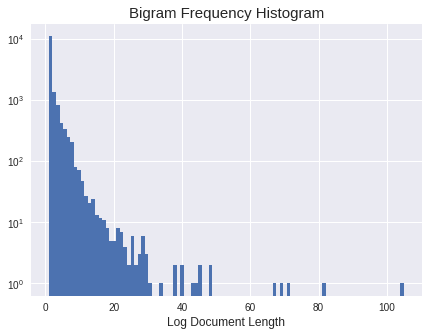

In [0]:
plt.figure(figsize =(7,5))
plt.hist(bigram_freq[bigram_freq>0], bins = 100, log = True)
plt.title('Bigram Frequency Histogram', size = 15)
plt.xlabel('Log Document Length', size = 12)

Text(0.5,0,'Minimum Distance')

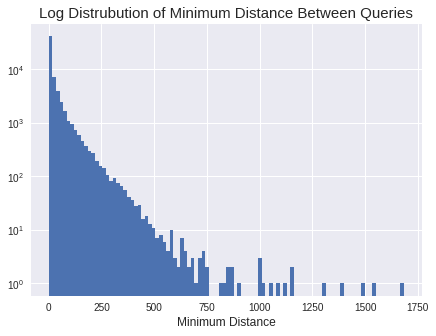

In [0]:
plt.figure(figsize =(7,5))
plt.hist(trec_tokenized.Min_Dist.loc[trec_tokenized.Min_Dist > 0].values, bins = 100, log = True)
plt.title('Log Distrubution of Minimum Distance Between Queries', size = 15)
plt.xlabel('Minimum Distance', size = 12)

Text(0.5,0,'Bigram Frequency')

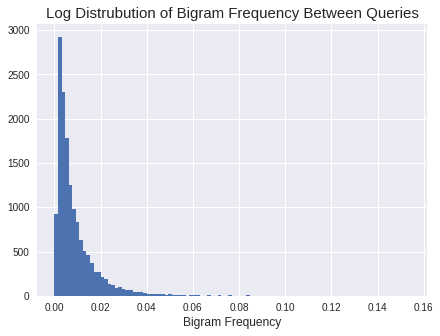

In [0]:
plt.figure(figsize =(7,5))
plt.hist(trec_tokenized.bigram_freq.loc[trec_tokenized.bigram_freq > 0].values, bins = 100, log = False)
plt.title('Log Distrubution of Bigram Frequency Between Queries', size = 15)
plt.xlabel('Bigram Frequency', size = 12)

In [0]:
np.mean(trec_tokenized.doc_length)

352.08614411247805

In [0]:
len(trec_tokenized.DOCNO)

142250

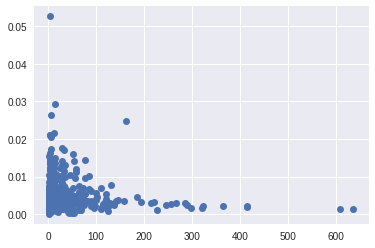

In [0]:
plt.plot(trec_tokenized.Min_Dist.loc[(trec_tokenized.bigram_freq > 0) & (trec_tokenized.Min_Dist > 1)].values, trec_tokenized.bigram_freq.loc[(trec_tokenized.bigram_freq >0) & (trec_tokenized.Min_Dist > 1)].values, 'o')

Text(0.5,0,'Minimum Distance')

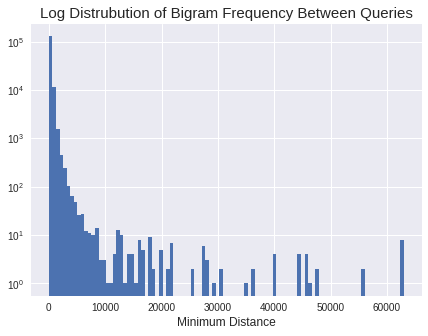

In [0]:
plt.figure(figsize =(7,5))
plt.hist(trec_tokenized.doc_length.values, bins = 100, log = True)
plt.title('Log Distrubution of Bigram Frequency Between Queries', size = 15)
plt.xlabel('Minimum Distance', size = 12)

Text(0,0.5,'Log Document Length')

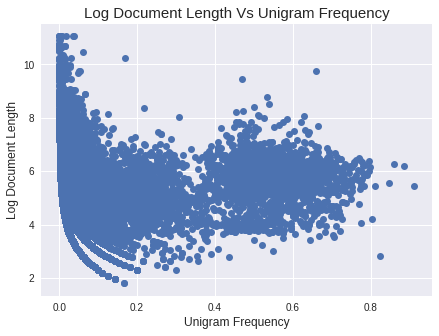

In [0]:
plt.figure(figsize =(7,5))
plt.plot(trec_tokenized.term_freq.loc[trec_tokenized.term_freq >0].values, np.log(trec_tokenized.doc_length.loc[trec_tokenized.term_freq >0].values), 'o')
plt.title('Log Document Length Vs Unigram Frequency', size = 15)
plt.xlabel('Unigram Frequency', size = 12)
plt.ylabel('Log Document Length', size = 12)

Text(0,0.5,'Log Document Length')

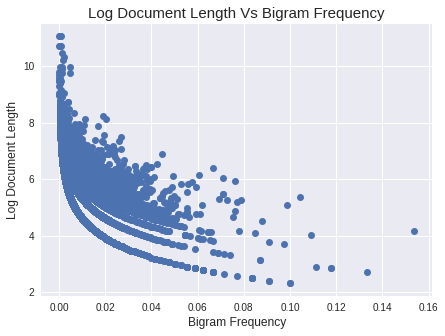

In [0]:
plt.figure(figsize =(7,5))
plt.plot(trec_tokenized.bigram_freq.loc[trec_tokenized.bigram_freq >0].values, np.log(trec_tokenized.doc_length.loc[trec_tokenized.bigram_freq >0].values), 'o')
plt.title('Log Document Length Vs Bigram Frequency', size = 15)
plt.xlabel('Bigram Frequency', size = 12)
plt.ylabel('Log Document Length', size = 12)

Text(0,0.5,'Log Document Length')

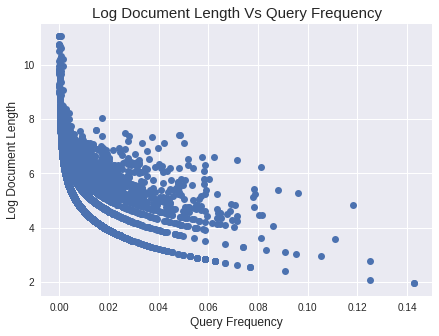

In [0]:
plt.figure(figsize =(7,5))
plt.plot(trec_tokenized.query_freq.loc[trec_tokenized.query_freq >0].values, np.log(trec_tokenized.doc_length.loc[trec_tokenized.query_freq >0].values), 'o')
plt.title('Log Document Length Vs Query Frequency', size = 15)
plt.xlabel('Query Frequency', size = 12)
plt.ylabel('Log Document Length', size = 12)

Text(0,0.5,'Log Document Length')

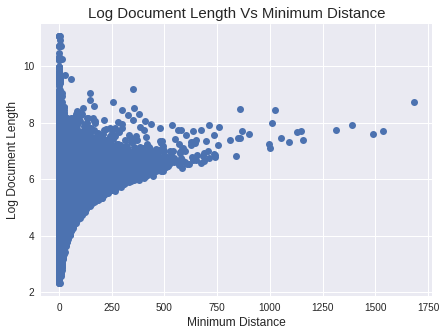

In [0]:
plt.figure(figsize =(7,5))
plt.plot(trec_tokenized.Min_Dist.loc[trec_tokenized.Min_Dist >0].values, np.log(trec_tokenized.doc_length.loc[trec_tokenized.Min_Dist >0].values), 'o')
plt.title('Log Document Length Vs Minimum Distance', size = 15)
plt.xlabel('Minimum Distance', size = 12)
plt.ylabel('Log Document Length', size = 12)

Text(0,0.5,'Log Document Length')

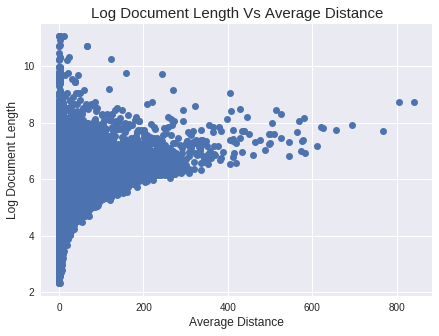

In [0]:
plt.figure(figsize =(7,5))
plt.plot(trec_tokenized.Avg_Dist.loc[trec_tokenized.Avg_Dist >0].values, np.log(trec_tokenized.doc_length.loc[trec_tokenized.Avg_Dist >0].values), 'o')
plt.title('Log Document Length Vs Average Distance', size = 15)
plt.xlabel('Average Distance', size = 12)
plt.ylabel('Log Document Length', size = 12)

Text(0,0.5,'Minimum Distance')

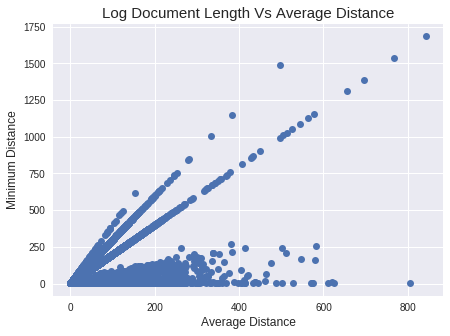

In [0]:
plt.figure(figsize =(7,5))
plt.plot(trec_tokenized.Avg_Dist.loc[trec_tokenized.Avg_Dist >0].values, trec_tokenized.Min_Dist.loc[trec_tokenized.Avg_Dist >0].values, 'o')
plt.title('Log Document Length Vs Average Distance', size = 15)
plt.xlabel('Average Distance', size = 12)
plt.ylabel('Minimum Distance', size = 12)